# **GDPR04. seq2seq 기반 번역기 만들기**

**INDEX**

00. 사용할 모듈 가져오기

01. 데이터 가져오기

02. 데이터 전처리

03. 데이터 토큰화

04. 어텐션 기반 seq2seq 설계

05. train & test

06. 회고

---

## **00. 사용할 모듈 가져오기**

In [1]:
# pip install konlpy

In [2]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm

import time
import re
import os
import io

import gzip
from konlpy.tag import Mecab

from tqdm import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 


print(tf.__version__)

2.8.2


In [4]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

## **01. 데이터 가져오기**

데이터는 아래의 것을 사용합니다.

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [5]:
url = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz'

In [6]:
def data_loader(url):
    # data download
    path_to_zip = tf.keras.utils.get_file('train_data', origin=url, extract=True)

    path_to_file_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
    path_to_file_en = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

    # ko data open
    with open(path_to_file_ko, 'r') as f:
        ko = f.read().splitlines()
    print("KO Data Size:", len(ko))
    print("Example:")
    for sen in ko[0:100][::20]: print(">>", sen)

    print("")

    # en data open
    with open(path_to_file_en, 'r') as f2:
        en = f2.read().splitlines()
    print("EN Data Size:", len(en))
    print("Example:")
    for sen in en[0:100][::20]: print(">>", sen)

    return ko, en

print("Done!")

Done!


In [7]:
ko_raw, en_raw = data_loader(url)

8732672/8718893 [==============================] - 0s 0us/step
KO Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.

EN Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether we

둘다 개수가 94123으로 잘 맞습니다.

## **02. 데이터 전처리**

### **2-1. 중복 제거**

In [8]:
# 중복 제거
zip_raw = zip(ko_raw, en_raw)
zip_raw

In [9]:
set_raw = set(zip_raw)
len(set_raw)

78968

In [10]:
cleaned_corpus_ko, cleaned_corpus_en = list(zip(*set_raw))

In [11]:
cleaned_corpus_ko[0]

'공교롭게도 용의자 8명 모두 의학계에 종사하고 있다.'

In [12]:
cleaned_corpus_en[0]

'All eight have links to the medical profession, according to sources with knowledge of the investigation.'

잘 처리되었습니다.

### **2-2. 정규식 표현**

In [13]:
# 정규식 표현 함수
def preprocessing(sentence, ko_token=False, en_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    if ko_token:
        mecab = Mecab()
        sentence = re.sub(r"[^?.!,^가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = mecab.morphs(sentence)

    if en_token:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = '<start> ' + sentence
        sentence += ' <end>'
    
    return sentence

print("Done!")    

Done!


In [14]:
# 토큰 추가, 40이하 잘라내기
kor_corpus = []
eng_corpus = []

for ko, en in zip(cleaned_corpus_ko, cleaned_corpus_en):
    temp_ko = preprocessing(ko, ko_token=True)
    temp_en = preprocessing(en, en_token=True)

    if (len(temp_ko) <= 40):
        kor_corpus.append(temp_ko)
        eng_corpus.append(temp_en)

print(kor_corpus[0])
print(eng_corpus[0])

['공교', '롭', '게', '도', '용의자', '명', '모두', '의학', '계', '에', '종사', '하', '고', '있', '다', '.']
<start> all eight have links to the medical profession , according to sources with knowledge of the investigation .  <end>


In [15]:
len(kor_corpus),len(eng_corpus)

(67016, 67016)

길이도 동일합니다. 이제 데이터를 토큰화합니다.

## **03. 데이터 토큰화**

In [16]:
vocab_size = 20000

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

print("Done!")

Done!


In [17]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

print("Done!")

Done!


In [18]:
print("ENC voca size: {}".format(len(enc_tokenizer.index_word)))
print("DEC voca size: {}".format(len(dec_tokenizer.index_word)))

ENC voca size: 38205
DEC voca size: 40219


잘 처리된 것 같습니다. 이제 모델을 설계합니다.

## **04. Attention 기반 seq2seq 모델 설계**

### **4-1. 어텐션 설계 (바다나우)**

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("Done!")

Done!


### **4-2. Encoder & Decoder 설계**

In [20]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

print("Done!")

Done!


### **4-3. 모델 구조 확인**

In [25]:
# 디폴트 64
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

# 디폴트 1024
units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 512)
Decoder Output: (64, 40220)
Decoder Hidden State: (64, 512)
Attention: (64, 30, 1)


### **4-4. optimizer & loss**

In [26]:
# Adam 사용
optimizer = tf.keras.optimizers.Adam()

# 다중카테고리 loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("Done!")

Done!


### **4-5. train_step**

In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("Done!")

Done!


## **05. train & test**

### **5-1. train**

In [28]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1048/1048 [08:27<00:00,  2.07it/s, Loss 1.1969]


### **5-2. test**

기본 모델로 학습한 결과를 테스트 해보겠습니다.

In [34]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocessing(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

print("Done!")

Done!


Input: 오바마는 대통령이다 . 
Predicted translation: the u . <end> 


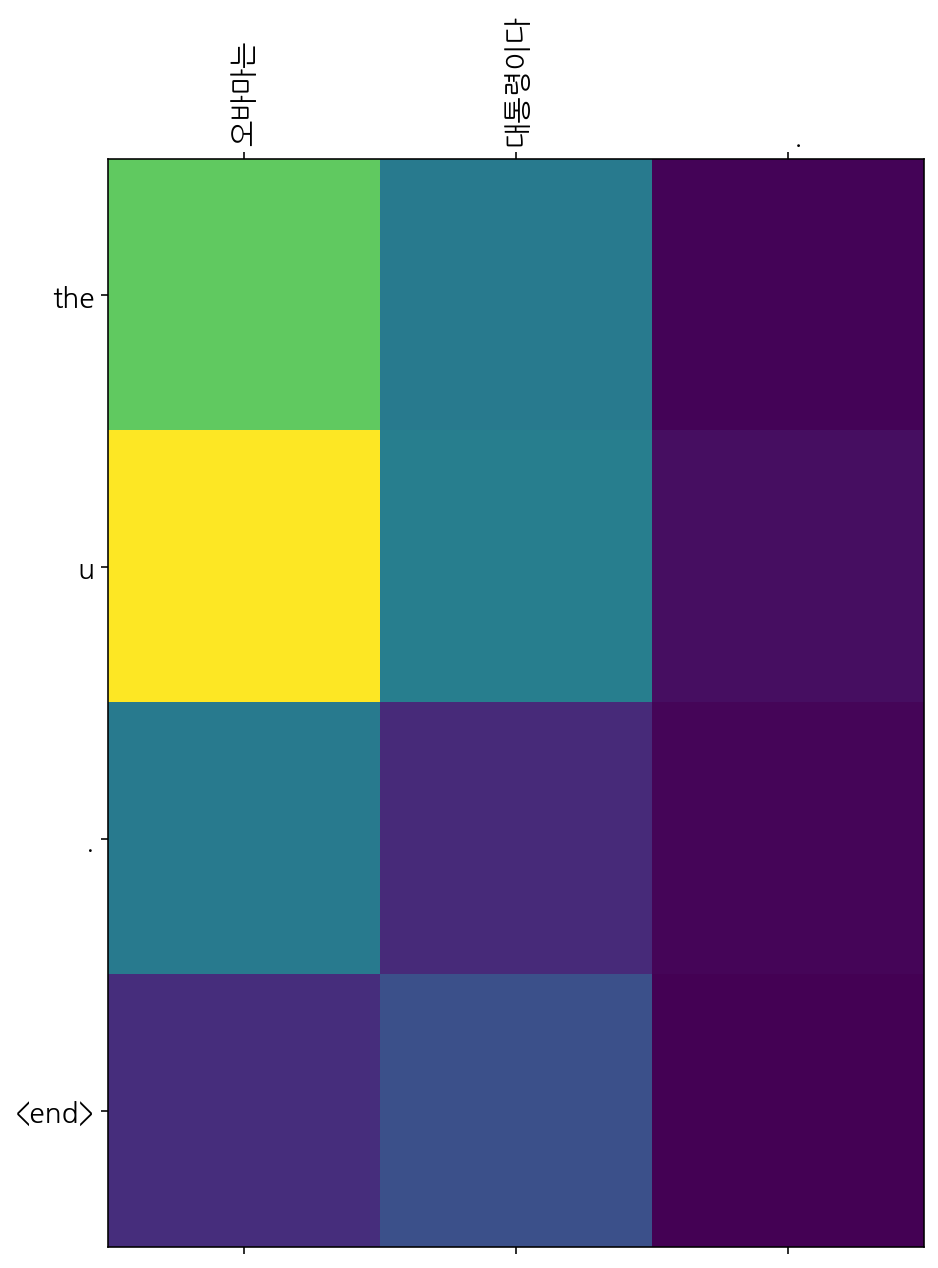

In [35]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 . 
Predicted translation: the city s largest city . <end> 


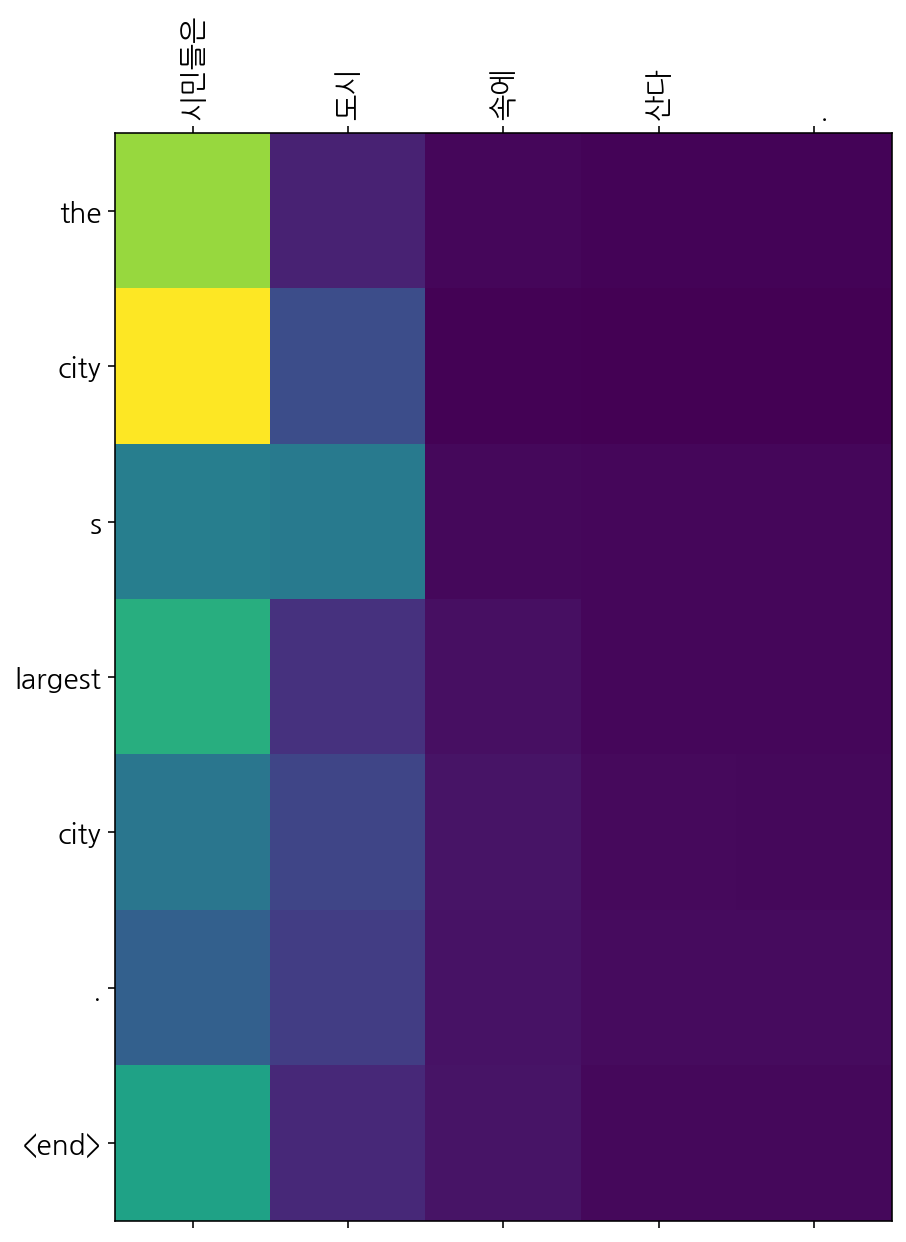

In [36]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 . 
Predicted translation: we re still , says it s a lot of the first time . <end> 


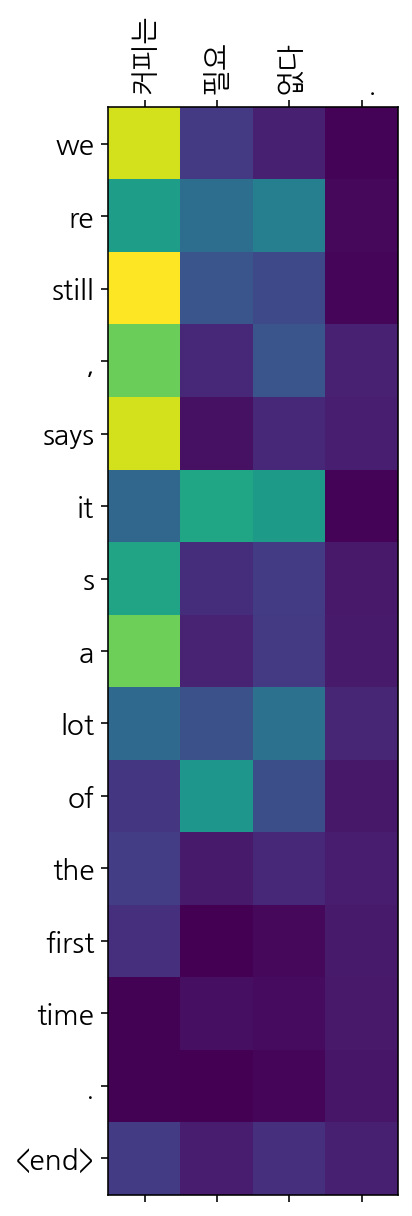

In [37]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 . 
Predicted translation: the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of the year old son of 


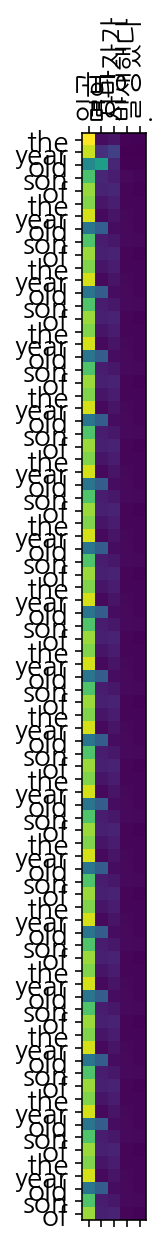

In [38]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

성능이 영 시원찮습니다.

일부 짧은 문장은 아예 번역이 안되기도 하네요.

## **06. 회고**

- 어텐션 구조를 잘 이해했다고 생각했는데 아닌 것 같습니다.

- 성능 개선을 위해 다양한 batch size, units, embedding dimension size 조절을 해봤는데 별로 의미가 없었습니다.

- 데이터의 숫자가 부족해서 그런 걸 수도 있을 것 같습니다.